In [1]:
import sys
import shutil
import os
import math
import time

from typing import List, Dict, Tuple, Union, Any, Callable
from typing import TextIO, BinaryIO
from collections import Counter, defaultdict,OrderedDict


import import_ipynb
sys.path.append('../')  # Go up two folders to the project root

from structures.InvertedIndex import Posting,InvertedIndex
from structures.Lexicon import Lexicon
from structures.LexiconRow import LexiconRow
from structures.DocumentIndex import DocumentIndex
from structures.DocumentIndexRow import DocumentIndexRow
from structures.BlockDescriptor import BlockDescriptorBuilder,BlockDescriptor
from building_data_structures.CollectionStatistics import  Collection_statistics
from pre_processing.Decompress_collection import Collection_Reader
from query_processing.Scoring import Scoring
from utilities.General_Utilities import get_memory_available,get_memory_usage

importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\structures\InvertedIndex.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\structures\LexiconRow.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\structures\DocumentIndex.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\utilities\General_Utilities.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\structures\DocumentIndexRow.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\utilities\Compression.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\structures\Lexicon.ipynb
importing Jupyter notebook from C:\Users\Davide\IR\Progetto\building_data_structures\..\building_data_structures\CollectionStatistics.ipynb
importing Jupyter notebook from C

In [2]:
# Costants

DIR_TEMP_FOLDER="TEMP"
DIR_TEMP_DOC_ID="DOC_ID_TEMP"
DIR_TEMP_FREQ="FREQ_TEMP"
DIR_TEMP_LEXICON="LEXICON_TEMP"

DIR_LEXICON="LEXICON"
DIR_DOC_INDEX="DOC_INDEX"
DIR_INVERTED_INDEX="INV_INDEX"

PATH_FINAL_LEXICON="lexicon.bin"
PATH_FINAL_DOC_IDS="doc_ids.bin"
PATH_FINAL_FREQ="freq.bin"
PATH_FINAL_BLOCK_DESCRIPTOR="block_descriptors.bin"
PATH_FINAL_DOCUMENT_INDEX="document_index.bin"


PATH_COLLECTION_STATISTICS="collection_statistics.bin"
PATH_COLLECTION_STATISTICS_DEBUG="collection_statistics.txt"

PATH_FINAL_INVERTED_INDEX_DEBUG="inverted_index.txt"
PATH_FINAL_LEXICON_DEBUG="lexicon.txt"
PATH_FINAL_DOCUMENT_INDEX_DEBUG="document_index.txt"

In [3]:
class IndexBuilder:

    debug_mode:bool
    compression_mode:bool
    collection_reader:Collection_Reader
    
    #For writing the final result
    file_Final_Lexicon:BinaryIO
    file_Final_DocIds:BinaryIO
    file_Final_Freq:BinaryIO
        
    file_Final_Block_Descriptor:BinaryIO
    file_Final_Document_Index:BinaryIO    
    
    file_Final_InvertedIndex_Debug:TextIO
    file_Final_Lexicon_Debug:TextIO
    file_Final_Document_Index_Debug:TextIO 
    
    #For merging operation
    input_lex_temp_files:List[BinaryIO]
    input_doc_id_temp_files:List[BinaryIO]
    input_freq_temp_files:List[BinaryIO]
        
    b_d_b:BlockDescriptorBuilder 
    coll_statistics: Collection_statistics
    scorer:Scoring
    
    def __init__(self,debug_mode:bool, compression_mode:bool,collection_reader:Collection_Reader)->None:
        """
            Default contructor method for initialization of IndexBuilder class.
        Args:
            debug_mode: if true, it enable the modality for a clear human readable debug.
            compression_mode: if true, it enable saving of posting list in a compression mode.
            collection_reader: the source of documents to be used for building the index
        
        """
        print ("Index Builder Costructor")
        
        self.debug_mode=debug_mode
        self.compression_mode=compression_mode
        self.collection_reader=collection_reader
        
        self.input_lex_temp_files = []
        self.input_doc_id_temp_files= []
        self.input_freq_temp_files= []
        
        self.coll_statistics=Collection_statistics(DIR_DOC_INDEX+"/"+PATH_COLLECTION_STATISTICS)
        
        
        self.b_d_b=BlockDescriptorBuilder("")
        
        print ("Using: ")
        print ("Debug Mode :"+str(debug_mode))
        print ("Compression Mode :"+str(compression_mode))
        print ("Nr of posting in each block descriptor: "+str(self.b_d_b.min_posting_list_size))
        print ("\n\n")
              
        
        
    def build_in_memory_index(self,list_of_documents:list)->InvertedIndex:
        """Given a list of document, build an Inverted Index in main Memory (RAM) and return it.
           !! THIS METHOD IS NOT USED TO BUILD THE EFFECTIVE INDEX !!
           
           This is used in test phase to check rapidly if the output obtained is correct or not.
        Args:
            list_of_documents: list of strings representing a document.
            
        Returns:
            An Inverted Index in memory object of the list_of_documents.
        """
        invertedIndex = InvertedIndex()
        for doc in list_of_documents:
            doc_list = doc.split()
            doc_id = int(doc_list[0])
            text = ' '.join(doc_list[1:])
            tc = Counter(text.lower().split())  # dict with term counts, QUI USARE DIRETTAMENTE IL CONTENUTO GIA' PRE-PROCESSATO
            for term, freq in tc.items():
                invertedIndex.add_posting(term, doc_id, freq)
        return invertedIndex

    def init_spimi(self)->None:
        """ Function to initialize a clear environment to start building the needed data structures for the spimi phase."""
        
        if os.path.exists(DIR_TEMP_FOLDER):
            shutil.rmtree(DIR_TEMP_FOLDER)

        os.makedirs(DIR_TEMP_FOLDER)
        os.makedirs(DIR_TEMP_FOLDER+"/"+DIR_TEMP_DOC_ID)
        os.makedirs(DIR_TEMP_FOLDER+"/"+DIR_TEMP_FREQ)
        os.makedirs(DIR_TEMP_FOLDER+"/"+DIR_TEMP_LEXICON)
        
        if os.path.exists(DIR_DOC_INDEX):
            shutil.rmtree(DIR_DOC_INDEX)
            
        os.makedirs(DIR_DOC_INDEX)
        
        self.__open_document_index_files()
        
        
    def init_index_merging(self)->None:
        """ Function to initialize a clear environment to start building the effective datastructures. """
        
        if os.path.exists(DIR_LEXICON):
            shutil.rmtree(DIR_LEXICON)
                
        if os.path.exists(DIR_INVERTED_INDEX):
            shutil.rmtree(DIR_INVERTED_INDEX)

        os.makedirs(DIR_LEXICON)
        os.makedirs(DIR_INVERTED_INDEX)
                    
        if (self.debug_mode):
            if os.path.exists(PATH_FINAL_INVERTED_INDEX_DEBUG):
                os.remove(PATH_FINAL_INVERTED_INDEX_DEBUG)
        
        self.coll_statistics.read_binary_mode()
        self.scorer=Scoring(self.coll_statistics)
        
        self.__open_files_for_merging_operation()
            
    
    def __open_document_index_files(self)->None:
        """ This function is designed to open the necessary file for the document_index data structure."""
        
        if (self.debug_mode):
            self.file_Final_Document_Index_Debug=open(DIR_DOC_INDEX+"/"+PATH_FINAL_DOCUMENT_INDEX_DEBUG, 'a')
        
        self.file_Final_Document_Index=open(DIR_DOC_INDEX+"/"+PATH_FINAL_DOCUMENT_INDEX, 'ab') 
         
    def __close_files_for_spimi_operation(self)->None:
        """ This function is designed to close the necessary file for the document_index data structure."""
        if (self.debug_mode):
            self.file_Final_Document_Index_Debug.close()
        
        self.file_Final_Document_Index.close()
        
    
    def __open_files_for_merging_operation(self)->None:
        """ Function to open the needed files for the merging operation. """
        
        file_lex_temp_paths = [DIR_TEMP_FOLDER+"/"+DIR_TEMP_LEXICON+"/"+f for f in os.listdir(DIR_TEMP_FOLDER+"/"+DIR_TEMP_LEXICON)]
        file_doc_id_temp_paths = [DIR_TEMP_FOLDER+"/"+DIR_TEMP_DOC_ID+"/"+f for f in os.listdir(DIR_TEMP_FOLDER+"/"+DIR_TEMP_DOC_ID)] 
        file_freq_temp_paths = [DIR_TEMP_FOLDER+"/"+DIR_TEMP_FREQ+"/"+f for f in os.listdir(DIR_TEMP_FOLDER+"/"+DIR_TEMP_FREQ)] 

        self.input_lex_temp_files = [open(file, 'rb') for file in file_lex_temp_paths]  #Open all the blocks in parallel
        self.input_doc_id_temp_files = [open(file, 'rb') for file in file_doc_id_temp_paths]  #Open all the blocks in parallel
        self.input_freq_temp_files = [open(file, 'rb') for file in file_freq_temp_paths]  #Open all the blocks in parallel
        
        self.file_Final_Lexicon=open(DIR_LEXICON+"/"+PATH_FINAL_LEXICON, 'ab') 
        self.file_Final_DocIds=open(DIR_INVERTED_INDEX+"/"+PATH_FINAL_DOC_IDS, 'ab') 
        self.file_Final_Freq=open(DIR_INVERTED_INDEX+"/"+PATH_FINAL_FREQ, 'ab') 
        self.file_Final_Block_Descriptor=open(DIR_INVERTED_INDEX+"/"+PATH_FINAL_BLOCK_DESCRIPTOR, 'ab')

        if (self.debug_mode):
            self.file_Final_InvertedIndex_Debug=open(DIR_INVERTED_INDEX+"/"+PATH_FINAL_INVERTED_INDEX_DEBUG,'a')
            self.file_Final_Lexicon_Debug=open(DIR_LEXICON+"/"+PATH_FINAL_LEXICON_DEBUG,'a')
            self.file_Final_Lexicon_Debug.write(LexiconRow.to_string_header()+"\n")
        
        
    def __close_files_for_merging_operation(self)->None:
        """ This function is used to close all the opened resource needed for the creation of the data structures
            in merging operation.
        """
        
        for file in self.input_lex_temp_files:
            file.close()  

        for file in self.input_doc_id_temp_files:
            file.close()  

        for file in self.input_freq_temp_files:
            file.close()  

        self.file_Final_Lexicon.close()
        self.file_Final_DocIds.close()
        self.file_Final_Freq.close()
        self.file_Final_Block_Descriptor.close()

        if (self.debug_mode):
            self.file_Final_InvertedIndex_Debug.close()
            self.file_Final_Lexicon_Debug.close()
        
    def __check_all_blocks_are_read(self,offset_lexicon_terms:List):
        """ This functions checks if the all the blocks opened in parallel are read or not.
            The condition is matched when the list contains all None elements. 
        Args:
            offset_lexicon_terms: a list of offset
        
        Returns:
            True if the list contains all None elements.
        """
        #print (offset_lexicon_terms)
        return sum(1 if element is None else 0 for element in offset_lexicon_terms) == len(offset_lexicon_terms)
    
    
    def __find_min_term(self,lexicon_temp_terms:List,offset_lex_temp:List):
        """ This function checks and returns the minimum term (lexicographically) among blocks 
             at the current reading offset.
             If a offset_lex_temp[i] contains None means that the i block is completely read.
             
         Args:
             lexicon_temp_terms: the list of current lexicon element (each position is a different block)
             offset_lexicon_terms: the list of current lexicon element position inside the file (each position is a different block)
         Return:
             a string representing the current min term or None if all blocks are read
         
        """
    
        if not lexicon_temp_terms:
            return None  # Return None for an empty list
    
        min_term=None

        for index,lex_elem in enumerate(lexicon_temp_terms):
            if(offset_lex_temp[index]!=None):
                if (min_term==None):
                    min_term=lexicon_temp_terms[index].term

                if (lex_elem.term<min_term):
                    min_term=lex_elem.term
    
        return min_term
    
    
    def __updateBM25TermUpperBoundInformation(self,lexicon_temp_terms:List,
                                              min_term:str,lex_row:LexiconRow):
        """ 
            This function is used to merge all the statistics on term upperbound discovered in the single blocks
            in order to obtain an unique and effective term upper bound.
            
            Args:
            lexicon_temp_terms: the set of the terms to search the effective min_term
            
            
        
        """
        
        #This variable is uses as temp to store the max ratio.
        lexRow_Max_upper=LexiconRow("")

        #For each lexicon term that is the current minimum compute the max term upperbound.
        for lex_elem in lexicon_temp_terms:
            if(lex_elem!=None and lex_elem.term==min_term):
                lexRow_Max_upper.update_term_upper_bound_bm25(lex_elem.BM25Tf,lex_elem.BM25Dl)
        
        lex_row.BM25Dl=lexRow_Max_upper.BM25Dl
        lex_row.BM25Tf=lexRow_Max_upper.BM25Tf

    
    
    def __save_postings_and_block_descriptor(self,new_term:bool,
                                             min_term:str,
                                             merged_posting_list:List[Posting],
                                             current_offset_doc_ids:int,current_offset_freq:int,
                                             current_offset_block_descriptor:int,
                                             block_descriptor:BlockDescriptor):
        """
        This function is used to save a posting list to related disk files calling the proper Inverted Index methods 
        and the related Block Descriptor.
        This function is created to avoid redundancy in the code considering that it is called in at least 2 points.
        
        Args:
            new_term: if true, in debug enabled is used to write different a new line in the output clear file.
            merged_posting_list: the posting list to be stored on disk
            current_offset_doc_ids: the offset position to save the doc ids of the merged_posting_list inside a file
            current_offset_freq: the offset position to save the freq of the merged_posting_list inside a file
            current_offset_block_descriptor: the offset position to save the block descriptor of the merged_posting_list inside a file
            block_descriptor: the block descriptor to use for saving on disk the information about the merged_posting_list
            
        Returns:
            current_offset_doc_ids: the new offset free position inside the file of the doc ids
            current_offset_freq: the new offset free position inside the file of the freq
            current_offset_block_descriptor: the new offset free position inside the file of the block descriptor
        
        """
        
        saved_offset_doc_ids=current_offset_doc_ids
        saved_offset_freq=current_offset_freq
        
        #Write the posting on disk.
        current_offset_doc_ids,current_offset_freq=InvertedIndex.write_to_files_a_posting_list(merged_posting_list,self.compression_mode,self.file_Final_DocIds,self.file_Final_Freq,current_offset_doc_ids,current_offset_freq)
        block_descriptor.nr_postings+=len(merged_posting_list)
                                
        block_descriptor.doc_ids_bytes_size=(current_offset_doc_ids-saved_offset_doc_ids)
        block_descriptor.freq_bytes_size=(current_offset_freq-saved_offset_freq)
                                
        block_descriptor.min_doc_id=merged_posting_list[0].doc_id
        block_descriptor.max_doc_id=merged_posting_list[-1].doc_id
                                
        #Writing the block descriptor.
        current_offset_block_descriptor=block_descriptor.write_block_descriptor_on_disk_to_opened_file(self.file_Final_Block_Descriptor,current_offset_block_descriptor)
        
        if (self.debug_mode):
            InvertedIndex.write_to_file_a_posting_list_debug_mode(self.file_Final_InvertedIndex_Debug,min_term, merged_posting_list, new_term)
        
        return current_offset_doc_ids,current_offset_freq,current_offset_block_descriptor
        
    
    
    def single_pass_in_memory_indexing(self,memory_dedicated_in_bytes: int=2200)-> None:
            """ The aim of this method is to handle the entire data collection, at fixed blocks previously set in collection_reader, 
                to create the relative partial inverted index, lexicon and document_index. 
                The amount of memory dedicated to this function is indicated in the parameter memory_dedicated_in_bytes. 
                When the memory threashold exceed, the data structures are then saved on temp files on disk. It's important to note
                that the inveted index is saved into a file in a lexicografical order and posting list term is order in ascending order of doc_id.
            Args:
                memory_dedicated_in_bytes: the amount of memory (in bytes) dedicated to this function

            """
            
            self.init_spimi()
            
            #Fixing the max memory threshold reachable
            ACT_MEM=get_memory_usage()
            MAX_MEM=ACT_MEM+memory_dedicated_in_bytes
            
            #Temp data structure in RAM
            ind = InvertedIndex()
            document_index = DocumentIndex()
            term_temp=LexiconRow("")

            #Counting variables
            nr_block=0
            doc_index_offset=0
            doc_id=0

            start_loop=time.time()
            
            try:
                #Read all the documents and write the index at blocks on disk when memory is full, cleaning the memory data structure.
                for doc in self.collection_reader:

                    if (get_memory_usage()>=MAX_MEM): # if the memory threshold is reached save temp data structure on disk.

                        LEXICON_TEMP_BLOCK_PATH=DIR_TEMP_FOLDER+"/"+DIR_TEMP_LEXICON+"/block_nr_"+str(nr_block)
                        DOC_IDS_TEMP_BLOCK_PATH=DIR_TEMP_FOLDER+"/"+DIR_TEMP_DOC_ID+"/block_nr_"+str(nr_block)
                        FREQ_TEMP_BLOCK_PATH=DIR_TEMP_FOLDER+"/"+DIR_TEMP_FREQ+"/block_nr_"+str(nr_block)

                        ind.write_to_block_all_index_in_memory(document_index,LEXICON_TEMP_BLOCK_PATH,DOC_IDS_TEMP_BLOCK_PATH,FREQ_TEMP_BLOCK_PATH)

                        if (self.debug_mode):
                                ind.write_to_block_debug_mode(DIR_TEMP_FOLDER+"/inv_index_"+str(nr_block)+".txt")

                        ind.clear_structure()
                        
                        if (self.debug_mode):
                            document_index.write_document_index_to_file_debug(self.file_Final_Document_Index_Debug)

                        doc_index_offset=document_index.write_document_index_to_file(self.file_Final_Document_Index,doc_index_offset)
                        document_index.clear_structure()
                        
                        
                        
                        nr_block=nr_block+1 


                    # Separate the doc_no from the content of the real document 
                    doc_list = doc.split()
                    
                    doc_no = str(doc_list[0])
                    text = ' '.join(doc_list[1:])

                    document_index.add_document(doc_id,doc_no,text)

                    tc = Counter(text.lower().split())  # dict with term counts, Here there is the already preprocessed content
                    for term, freq in tc.items():
                        
                        term=term.ljust(term_temp.MAX_TERM_LENGTH)[:term_temp.MAX_TERM_LENGTH]
                        ind.add_posting(term, doc_id, freq)


                    if (doc_id%100000==0):
                        end_part_loop=time.time()

                        print("SPMI doc processed: "+str(doc_id)+" Time spent :"+str(end_part_loop-start_loop))
                        start_loop=time.time()
                        
                    doc_id+=1

                #Finally, saving the last remaing block, if (remains something)  

                if (not ind.is_empty()):
                    LEXICON_TEMP_BLOCK_PATH=DIR_TEMP_FOLDER+"/"+DIR_TEMP_LEXICON+"/block_nr_"+str(nr_block)
                    DOC_IDS_TEMP_BLOCK_PATH=DIR_TEMP_FOLDER+"/"+DIR_TEMP_DOC_ID+"/block_nr_"+str(nr_block)
                    FREQ_TEMP_BLOCK_PATH=DIR_TEMP_FOLDER+"/"+DIR_TEMP_FREQ+"/block_nr_"+str(nr_block)

                    ind.write_to_block_all_index_in_memory(document_index,LEXICON_TEMP_BLOCK_PATH,DOC_IDS_TEMP_BLOCK_PATH,FREQ_TEMP_BLOCK_PATH)

                    if (self.debug_mode):
                        ind.write_to_block_debug_mode(DIR_TEMP_FOLDER+"/inv_index_"+str(nr_block)+".txt")
                        
                if (not document_index.is_empty()):   
                    if (self.debug_mode):
                        document_index.write_document_index_to_file_debug(self.file_Final_Document_Index_Debug)
                    doc_index_offset=document_index.write_document_index_to_file(self.file_Final_Document_Index,doc_index_offset)

                self.coll_statistics.num_documents=document_index.number_of_documents
                self.coll_statistics.sum_document_lengths=document_index.total_document_length

                self.coll_statistics.write_binary_mode()
                if (self.debug_mode):
                    self.coll_statistics.save_statistics(DIR_DOC_INDEX+"/"+PATH_COLLECTION_STATISTICS_DEBUG)
            
            except Exception as e:   
                raise e
            finally:
                self.__close_files_for_spimi_operation()
            
        
    def index_merging(self)-> None:
        """ This aim of this method is to merge all the partial data structure processed in the previous method 
            single_pass_in_memory_indexing in order to create a unique ordered inverted index and lexicon. 
            The idea is to open all blocks in parallel and selecting at each time the term that is 
            lexicografical lower then others, then merging and sorting its posting lists. It can be possibile because
            the maximum number of posting that can be loaded into memory is given by the size of the block descriptor, so we are sure that 
            and at the end the final posting list of a term will be ordered by doc_id and can be loaded partially in
            main memory.
        """

        self.init_index_merging()
        
        try:

            #Initialization of empty lexicon row elements for each block.
            lexicon_temp_elems=[LexiconRow("",0) for i in range (len (self.input_lex_temp_files))]
            
            #Start reading the first element in the lexicon of each block and saving the offset of each read.
            offset_lex_temp=[terms.read_lexicon_row_on_disk_from_opened_file(self.input_lex_temp_files[index],0) for index,terms in enumerate(lexicon_temp_elems)]
            
            
            #Counting variables
            number_of_distinct_terms=0
            
            current_offset_lexicon=0
            current_offset_doc_ids=0
            current_offset_freq=0
            current_offset_block_descriptor=0

            #Until all the blocks are read, this means if there is a term to process enter in this part. 
            while (not self.__check_all_blocks_are_read(offset_lex_temp)):

                start_loop=time.time()
                
                #Find the minimum term among the opened blocks.
                min_term=self.__find_min_term(lexicon_temp_elems,offset_lex_temp)
                tot_posting=sum(lex_elem.dft if (lex_elem.term==min_term) else 0 for lex_elem in lexicon_temp_elems) 

                #This variable is used to mark if it is the first time a new term is elaborated among blocks, to print in debug a new line.
                new_term=True
                
                #print("\nMin termine corrente: "+min_term+ " nr. postings: "+str(tot_posting))
                
                #New Term to add definitively to final NEW LEXICON datastructure
                new_Lexicon_Def=LexiconRow(min_term,tot_posting)
                new_Lexicon_Def.docidOffset=current_offset_doc_ids
                new_Lexicon_Def.frequencyOffset=current_offset_freq
                new_Lexicon_Def.blockOffset=current_offset_block_descriptor 
                
                self.__updateBM25TermUpperBoundInformation(lexicon_temp_elems,min_term,new_Lexicon_Def)
                
                #Here I take from BlockDescriptorBuilder the number of blocks needed to save the current postings for the current term.
                new_Lexicon_Def.numBlocks=self.b_d_b.get_number_of_blocks(tot_posting)
                
                nr_of_postings_per_block_descriptor=math.ceil(tot_posting/new_Lexicon_Def.numBlocks)
                
                
                #Initialization of empty block descriptor.
                block_descriptor=BlockDescriptor(0,current_offset_doc_ids,current_offset_freq,0,0,0,0)
                
                #Temp variables for postings among different file blocks
                merged_posting_list=[]
                MAX_TF=0 
                
                #Number of postings that I can load in memory (RAM).
                readable_postings=nr_of_postings_per_block_descriptor-len(merged_posting_list)
                
                for index,lex_term in enumerate(lexicon_temp_elems):
                    
                    if (lex_term.term==min_term):
                        
                        #Nr of posting in this block "file".
                        posting_to_be_read=lex_term.dft
                        
                        doc_id_block_offset=lex_term.docidOffset
                        freq_block_offset=lex_term.frequencyOffset
                        
                        #There are still some posting related to this min_term to be read in this block. 
                        #This is done to avoid to load the entire posting list in RAM that may not be possible if posting is huge.
                        while(posting_to_be_read>0):
                            
                            #Here I can read in one shot all the posting list of that term in the block in memory.
                            if (posting_to_be_read<readable_postings):
                                nr_eff_readable=posting_to_be_read
                                posting_to_be_read=0
                            else:
                                #I read just what can be "currently" contained in main memory until block descriptor is full.
                                nr_eff_readable=readable_postings
                                posting_to_be_read-=readable_postings
                                                        
                            postingList,doc_id_block_offset,freq_block_offset=InvertedIndex.read_from_files_a_posting_list(
                                                                                self.input_doc_id_temp_files[index],self.input_freq_temp_files[index],
                                                                                False,
                                                                                doc_id_block_offset,freq_block_offset,
                                                                                nr_eff_readable)  
                            #print(postingList) 
                            
                            curr_max_tf=InvertedIndex.compute_max_term_frequency_of_posting_list(postingList)
                            if (curr_max_tf>MAX_TF):
                                MAX_TF=curr_max_tf  #Updating the new_maximum term frequency.
                            
                            #I combine the posting I have just read with those read previously
                            merged_posting_list=InvertedIndex.merge_posting_lists(merged_posting_list,postingList)
                            
                            readable_postings=nr_of_postings_per_block_descriptor-len(merged_posting_list)
                            
                            if(readable_postings==0):
                               
                                #I write the complete posting to disk (with possible compression) and the related block descriptor.
                                current_offset_doc_ids,current_offset_freq,current_offset_block_descriptor= self.__save_postings_and_block_descriptor(new_term,min_term,
                                                                          merged_posting_list,
                                                                          current_offset_doc_ids,current_offset_freq,
                                                                          current_offset_block_descriptor,
                                                                          block_descriptor)
                                new_term=False
                                
                                #Re-set the datastructures for new block descriptor.
                                merged_posting_list.clear()
                                block_descriptor=BlockDescriptor(0,current_offset_doc_ids,current_offset_freq,0,0,0,0)
                                readable_postings=nr_of_postings_per_block_descriptor
                        
                        ### END-WHILE ###
                       ### END - IF 
                    
                        # I read the next lexicon term related to this block file.
                        offset_lex_temp[index]=lex_term.read_lexicon_row_on_disk_from_opened_file(self.input_lex_temp_files[index],offset_lex_temp[index])
                
                ### END-FOR 
                
                if (len(merged_posting_list)>0):
            
                    #Here I finish to write the remaining posting list to disk and the related block descriptor.
                    current_offset_doc_ids,current_offset_freq,current_offset_block_descriptor= self.__save_postings_and_block_descriptor(new_term,min_term,merged_posting_list,
                                                                          current_offset_doc_ids,current_offset_freq,
                                                                          current_offset_block_descriptor,
                                                                          block_descriptor)
                
                 
                #Here I compute the offline metrics and complete the remaining information to lexicon term 
                # in order to save time for future online execution of the query.
                
                new_Lexicon_Def.idft=self.scorer.compute_IDFT(tot_posting)
                new_Lexicon_Def.max_tf=MAX_TF
                new_Lexicon_Def.maxTFIDF=self.scorer.compute_TFIDF(MAX_TF,new_Lexicon_Def.idft)
                
                new_Lexicon_Def.maxBM25=self.scorer.compute_term_upper_bound_bm25(new_Lexicon_Def)
                if (min_term=='a'.ljust(30)):
                    print(new_Lexicon_Def.maxBM25)
                    print(new_Lexicon_Def.BM25Dl)
                    print(new_Lexicon_Def.BM25Tf)
                    

                new_Lexicon_Def.docidSize=(current_offset_doc_ids-new_Lexicon_Def.docidOffset)
                new_Lexicon_Def.frequencySize=(current_offset_freq-new_Lexicon_Def.frequencyOffset)
                
                #Save all the information related to the term just elaborated to disk.
                if (self.debug_mode):
                    new_Lexicon_Def.write_lexicon_row_on_disk_debug_mode(self.file_Final_Lexicon_Debug)
                current_offset_lexicon=new_Lexicon_Def.write_lexicon_row_on_disk_to_opened_file(self.file_Final_Lexicon,current_offset_lexicon)
                
                number_of_distinct_terms+=1
                
                end_part_loop=time.time()  
                print("Merging term processed: "+min_term+" Time spent :"+str(end_part_loop-start_loop))
            
            #When the procedure is finished save the statistic of the collection.
            self.coll_statistics.num_distinct_terms=number_of_distinct_terms
            self.coll_statistics.write_binary_mode()
            if (self.debug_mode):
                self.coll_statistics.save_statistics(DIR_DOC_INDEX+"/"+PATH_COLLECTION_STATISTICS_DEBUG)
#             
            print("END METHOD!")   
            
        except Exception as e:   
                raise e
        finally:
                #Be sure to close all the opened files in parallel
                self.__close_files_for_merging_operation()
      

# Example of usage

In [4]:
tot_doc=[
    "0     The pen is on the table",
    "1     The day is very sunny",
    "2     Goodmoring new article",
    "3     A cat is faster then a dog",
    "4     How are you",
    "5     A boy is a man with low age",
    "6     Lake Ontario is one of the biggest lake in the world",
    "7     English is worst than Italian",
    "8     Spiderman is the best superhero in Marvel universe",
    "9     Last night I saw a Netflix series",
    "10    A penny for your thoughts",
    "11    Actions speak louder than words",
    "12    All that glitters is not gold",
    "13    Beauty is in the eye of the beholder",
    "14    Birds of a feather flock together",
    "15    Cleanliness is next to godliness",
    "16    Don't count your chickens before they hatch",
    "17    Every people cloud has a silver lining people",
    "18    Fool me once shame on you fool me twice shame on me",
    "19    Honesty is the best policy.",
    "20    If the shoe fits, wear it",
    "21    It's a piece of cake",
    "22    Jump on the bandwagon",
    "23    Keep your chin up",
    "24    Let the cat out of the bag",
    "25    Make a long story short",
    "26    Necessity is the mother of invention",
    "27    Once in a blue moon",
    "28    Practice makes perfect",
    "29    Read between the lines",
    "30    The early bird catches people the worm",
    "31    The pen is mightier than the sword",
    "32    There's no smoke without fire",
    "33    To each his own",
    "34    Two heads are better than one",
    "35    You can't have your cake and eat it too",
    "36    A watched pot never boils",
    "37    Beggars can't be choosers",
    "38    Better late than never",
    "39    Calm before the storm",
    "40    Curiosity killed the cat",
    "41    Every dog has its day",
    "42    Great minds think alike",
    "43    Hope for the best prepare for the worst",
    "44    Ignorance is bliss.",
    "45    It's the last straw that breaks the camel's back",
    "46    Laugh and the world laughs with you weep and you weep alone",
    "47    Money can't buy happiness",
    "48    No news is good news",
    "49    Out of sight out of mind",
    "50    People who live in glass houses shouldn't throw stones",
    "51    Rome wasn't built in a day",
    "52    Silence is golden",
    "53    The apple doesn't fall far from the tree",
    "54    The more, the merrier",
    "55    There's no place like home",
    "56    Two wrongs don't make a right",
    "57    When in Rome do as the Romans do",
    "58    You reap what you sow",
    "59    People people people"
]


#indexBuilder=IndexBuilder()
#indexBuilder.build_block_sort_base_indexing(tot_doc,"complete_inverted_index",2220,False,False)

In [6]:
# indexBuilder=IndexBuilder(True,True,Collection_Reader("",-1,-1,False,False,tot_doc))
# #invIndex=indexBuilder.build_in_memory_index(tot_doc)
# indexBuilder.single_pass_in_memory_indexing(2220)
# indexBuilder.index_merging()

Collection_Reader Costructor
Using: 
Testing Mode : True
No. of documents in the test collection: 60
No. of parallel processes=1, you can execute it also inside a jupyter notebook.


Index Builder Costructor
Using: 
Debug Mode :True
Compression Mode :True
Nr of posting in each block descriptor: 512



SPMI doc processed: 0 Time spent :0.0
0.5284552845528455
7
2
Merging term processed: a                              Time spent :0.0
Merging term processed: actions                        Time spent :0.0
Merging term processed: age                            Time spent :0.0
Merging term processed: alike                          Time spent :0.0
Merging term processed: all                            Time spent :0.0
Merging term processed: alone                          Time spent :0.0
Merging term processed: and                            Time spent :0.0
Merging term processed: apple                          Time spent :0.0010209083557128906
Merging term processed: are                       

In [8]:
# import heapq

# class TermFrequencyPair:
#     def __init__(self, term, frequency):
#         self.term = term
#         self.frequency = frequency

#     # For custom comparison in the heap
#     def __lt__(self, other):
#         return self.frequency > other.frequency

# class MaxHeap:
#     def __init__(self, max_size):
#         self.max_size = max_size
#         self.heap = []

#     def push(self, pair):
#         if len(self.heap) < self.max_size:
#             heapq.heappush(self.heap, pair)
#         else:
#             heapq.heappush(self.heap, pair)
                

#     def pop(self):
#         return heapq.heappop(self.heap)

#     def is_empty(self):
#         return len(self.heap) == 0




# lexicon_file=open(DIR_LEXICON+"/"+PATH_FINAL_LEXICON, 'rb') 

# lexRow=LexiconRow("")

# offset=0
# counters=[0,0,0,0,0]
# max_heap = MaxHeap(max_size=10)

# summary={}

# while(True):
#     offset=lexRow.read_lexicon_row_on_disk_from_opened_file(lexicon_file,offset)
#     if (offset==None):
#         break
#     tf_elem=TermFrequencyPair(lexRow.term.strip(),lexRow.dft)
#     max_heap.push(tf_elem)
    
#     if (lexRow.dft not in summary):
#         summary[lexRow.dft]=1
#     else:
#         summary[lexRow.dft]+=1
    
# #     if (lexRow.dft==1):
# #         counters[0]+=1
    
# #     if (lexRow.dft>1 and lexRow.dft<=512):
# #         counters[1]+=1
    
# #     if (lexRow.dft>512 and lexRow.dft<=1024):
# #         counters[2]+=1
    
# #     if (lexRow.dft>1024 and lexRow.dft<=4096):
# #         counters[3]+=1
    
# #     if (lexRow.dft>4096 ):
# #         counters[4]+=1
    
#     #print(lexRow.term.strip())

# lexicon_file.close()

# counters

[0, 0, 0, 0, 0]

In [13]:
# summary

{194039: 1,
 75250: 1,
 273133: 1,
 1077: 7,
 106: 277,
 55: 739,
 38: 1339,
 31: 1879,
 5: 38275,
 6: 27896,
 3: 96570,
 2: 206742,
 4: 57348,
 1: 743263,
 10: 13059,
 18: 4716,
 37: 1484,
 40: 1256,
 17: 4931,
 108: 293,
 11: 10628,
 12: 9231,
 8: 17490,
 115: 261,
 9: 14862,
 34: 1628,
 7: 21375,
 23: 3173,
 14: 6991,
 15: 6020,
 13: 7797,
 711: 21,
 16: 5636,
 224: 83,
 57: 797,
 231: 71,
 220: 96,
 214: 95,
 95: 336,
 72: 512,
 80: 443,
 122: 227,
 77: 482,
 19: 4263,
 126: 220,
 28: 2314,
 30: 1990,
 62: 610,
 48: 912,
 211: 92,
 22: 3378,
 50: 860,
 29: 2089,
 124: 245,
 142: 188,
 20: 3863,
 229: 103,
 39: 1300,
 3922: 3,
 120: 244,
 24: 2940,
 45: 1069,
 56: 738,
 93: 375,
 32: 1778,
 36: 1437,
 58: 687,
 47: 946,
 25: 2766,
 1084: 9,
 102: 288,
 33: 1736,
 42: 1222,
 89: 358,
 35: 1632,
 951: 17,
 27: 2369,
 864: 16,
 1023: 9,
 21: 3459,
 805: 11,
 41: 1201,
 1144: 11,
 812: 16,
 612: 26,
 153: 159,
 2505: 4,
 44: 1042,
 146: 184,
 150: 165,
 2800: 1,
 74: 435,
 90: 364,
 183

In [10]:
# summary
# weight_sum=sum(summary.values())
# weighted_sum =0

# for key,value in summary.items():
#     weighted_sum+=(key*value)
    
    
# weighted_average = weighted_sum / weight_sum
# weighted_average    

246.84864445864744

In [14]:
#sorted_dict = dict(sorted(summary.items(), key=lambda item: item[0], reverse=False))
#sorted_dict
#len(list(sorted_dict.values()))

{1: 743263,
 2: 206742,
 3: 96570,
 4: 57348,
 5: 38275,
 6: 27896,
 7: 21375,
 8: 17490,
 9: 14862,
 10: 13059,
 11: 10628,
 12: 9231,
 13: 7797,
 14: 6991,
 15: 6020,
 16: 5636,
 17: 4931,
 18: 4716,
 19: 4263,
 20: 3863,
 21: 3459,
 22: 3378,
 23: 3173,
 24: 2940,
 25: 2766,
 26: 2554,
 27: 2369,
 28: 2314,
 29: 2089,
 30: 1990,
 31: 1879,
 32: 1778,
 33: 1736,
 34: 1628,
 35: 1632,
 36: 1437,
 37: 1484,
 38: 1339,
 39: 1300,
 40: 1256,
 41: 1201,
 42: 1222,
 43: 1141,
 44: 1042,
 45: 1069,
 46: 1004,
 47: 946,
 48: 912,
 49: 849,
 50: 860,
 51: 830,
 52: 849,
 53: 828,
 54: 774,
 55: 739,
 56: 738,
 57: 797,
 58: 687,
 59: 721,
 60: 711,
 61: 627,
 62: 610,
 63: 622,
 64: 609,
 65: 646,
 66: 579,
 67: 566,
 68: 570,
 69: 576,
 70: 552,
 71: 507,
 72: 512,
 73: 483,
 74: 435,
 75: 471,
 76: 465,
 77: 482,
 78: 483,
 79: 418,
 80: 443,
 81: 412,
 82: 415,
 83: 402,
 84: 383,
 85: 376,
 86: 375,
 87: 389,
 88: 342,
 89: 358,
 90: 364,
 91: 352,
 92: 344,
 93: 375,
 94: 339,
 95: 336,


In [99]:
#summary

{194039: 1,
 75250: 1,
 273133: 1,
 1077: 7,
 106: 277,
 55: 739,
 38: 1339,
 31: 1879,
 5: 38275,
 6: 27896,
 3: 96570,
 2: 206742,
 4: 57348,
 1: 743263,
 10: 13059,
 18: 4716,
 37: 1484,
 40: 1256,
 17: 4931,
 108: 293,
 11: 10628,
 12: 9231,
 8: 17490,
 115: 261,
 9: 14862,
 34: 1628,
 7: 21375,
 23: 3173,
 14: 6991,
 15: 6020,
 13: 7797,
 711: 21,
 16: 5636,
 224: 83,
 57: 797,
 231: 71,
 220: 96,
 214: 95,
 95: 336,
 72: 512,
 80: 443,
 122: 227,
 77: 482,
 19: 4263,
 126: 220,
 28: 2314,
 30: 1990,
 62: 610,
 48: 912,
 211: 92,
 22: 3378,
 50: 860,
 29: 2089,
 124: 245,
 142: 188,
 20: 3863,
 229: 103,
 39: 1300,
 3922: 3,
 120: 244,
 24: 2940,
 45: 1069,
 56: 738,
 93: 375,
 32: 1778,
 36: 1437,
 58: 687,
 47: 946,
 25: 2766,
 1084: 9,
 102: 288,
 33: 1736,
 42: 1222,
 89: 358,
 35: 1632,
 951: 17,
 27: 2369,
 864: 16,
 1023: 9,
 21: 3459,
 805: 11,
 41: 1201,
 1144: 11,
 812: 16,
 612: 26,
 153: 159,
 2505: 4,
 44: 1042,
 146: 184,
 150: 165,
 2800: 1,
 74: 435,
 90: 364,
 183

In [11]:
# average = sum(list(sorted_dict.values())) / len(list(sorted_dict.values()))
# print(average)

139.0132162840054


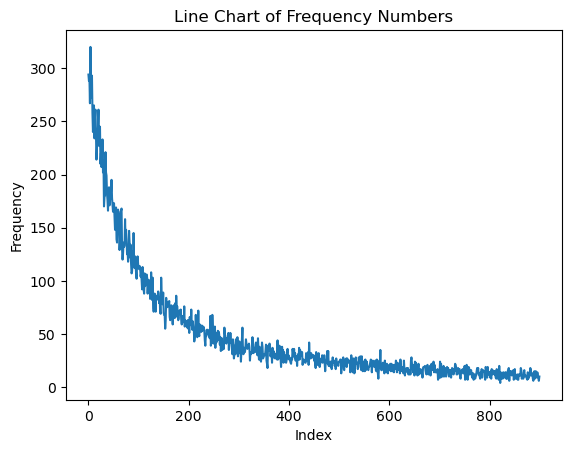

In [20]:
# import matplotlib.pyplot as plt

# # Sample data (replace this with your frequency numbers)
# frequency_numbers = [5, 3, 8, 2, 7]

# # Create a line chart
# plt.plot(list(sorted_dict.values())[100:1000], linestyle='-')

# # Add labels and title
# plt.xlabel('Index')
# plt.ylabel('Frequency')
# plt.title('Line Chart of Frequency Numbers')

# # Display the plot
# plt.show()

In [43]:
# while not max_heap.is_empty():
#     popped_pair = max_heap.pop()
#     print(f"Term: {popped_pair.term}, Frequency: {popped_pair.frequency}")

Term: the, Frequency: 7714106
Term: of, Frequency: 6561376
Term: and, Frequency: 6432017
Term: a, Frequency: 5906704
Term: to, Frequency: 5847118
Term: in, Frequency: 5319104
Term: is, Frequency: 4797071
Term: for, Frequency: 3438850
Term: that, Frequency: 2684370
Term: or, Frequency: 2618507
Term: on, Frequency: 2449548
Term: with, Frequency: 2361781
Term: are, Frequency: 2361051
Term: it, Frequency: 2268670
Term: as, Frequency: 2207381
Term: s, Frequency: 2106347
Term: you, Frequency: 1956470
Term: by, Frequency: 1849044
Term: from, Frequency: 1822038
Term: be, Frequency: 1767108
Term: an, Frequency: 1707039
Term: 1, Frequency: 1666077
Term: this, Frequency: 1648795
Term: can, Frequency: 1633942
Term: your, Frequency: 1465157
Term: at, Frequency: 1448620
Term: 2, Frequency: 1366638
Term: have, Frequency: 1282233
Term: not, Frequency: 1172036
Term: if, Frequency: 1083601
Term: one, Frequency: 1023314
Term: 3, Frequency: 994770
Term: which, Frequency: 989025
Term: was, Frequency: 96443

Term: divination, Frequency: 337
Term: nailing, Frequency: 337
Term: myositis, Frequency: 337
Term: asteraceae, Frequency: 337
Term: metamucil, Frequency: 337
Term: cusps, Frequency: 337
Term: copperhead, Frequency: 337
Term: const, Frequency: 337
Term: commissary, Frequency: 337
Term: 500k, Frequency: 337
Term: clickable, Frequency: 337
Term: wolfram, Frequency: 337
Term: 120v, Frequency: 337
Term: waller, Frequency: 337
Term: incubators, Frequency: 337
Term: imitating, Frequency: 337
Term: agoraphobia, Frequency: 337
Term: v5, Frequency: 337
Term: umbrellas, Frequency: 337
Term: hydrant, Frequency: 337
Term: hors, Frequency: 337
Term: horribly, Frequency: 337
Term: carer, Frequency: 337
Term: teriyaki, Frequency: 337
Term: cambria, Frequency: 337
Term: haw, Frequency: 337
Term: ca2, Frequency: 337
Term: sulfite, Frequency: 337
Term: guerrero, Frequency: 337
Term: gracefully, Frequency: 337
Term: sliver, Frequency: 337
Term: brats, Frequency: 337
Term: gasp, Frequency: 337
Term: sami,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Term: dimv, Frequency: 2
Term: dimunition, Frequency: 2
Term: multilobulated, Frequency: 2
Term: multilobular, Frequency: 2
Term: 684702, Frequency: 2
Term: multilith, Frequency: 2
Term: ildanach, Frequency: 2
Term: multilinkers, Frequency: 2
Term: 250sl, Frequency: 2
Term: multilinguist, Frequency: 2
Term: asphaltos, Frequency: 2
Term: dimsums, Frequency: 2
Term: dimsum, Frequency: 2
Term: multiligament, Frequency: 2
Term: multilib, Frequency: 2
Term: 684668, Frequency: 2
Term: asphaltics, Frequency: 2
Term: dimscreen, Frequency: 2
Term: 1000xt, Frequency: 2
Term: dimpylate, Frequency: 2
Term: dimrill, Frequency: 2
Term: multilatino, Frequency: 2
Term: dimpy, Frequency: 2
Term: wknds, Frequency: 2
Term: 68462, Frequency: 2
Term: multilab, Frequency: 2
Term: multikey, Frequency: 2
Term: multikinase, Frequency: 2
Term: 03dm, Frequency: 2
Term: dimpflmeier, Frequency: 2
Term: usgpm, Frequency: 2
Term: 68455, Frequency: 2
Term: multihome, Frequency: 2
Term: dimotiki, Frequency: 2
Term: mu

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Term: williamtown, Frequency: 1
Term: 04030, Frequency: 1
Term: pinagtikangan, Frequency: 1
Term: w0312, Frequency: 1
Term: unetsubo, Frequency: 1
Term: ati_website, Frequency: 1
Term: sebta, Frequency: 1
Term: veriflo, Frequency: 1
Term: nagelaat, Frequency: 1
Term: 6x6x53, Frequency: 1
Term: nagct, Frequency: 1
Term: rdtarrytown, Frequency: 1
Term: gukseon, Frequency: 1
Term: dm400c, Frequency: 1
Term: tuesdayst, Frequency: 1
Term: dm3cm, Frequency: 1
Term: navnut, Frequency: 1
Term: navne, Frequency: 1
Term: safeserv, Frequency: 1
Term: dm2020, Frequency: 1
Term: navmap, Frequency: 1
Term: athylenglykol, Frequency: 1
Term: disrooting, Frequency: 1
Term: 100618696, Frequency: 1
Term: syndromethis, Frequency: 1
Term: dm1200, Frequency: 1
Term: nagate, Frequency: 1
Term: 6x5x3, Frequency: 1
Term: filmmagicafter, Frequency: 1
Term: naviserver, Frequency: 1
Term: cchan, Frequency: 1
Term: tooptimise, Frequency: 1
Term: veeps, Frequency: 1
Term: athurs, Frequency: 1
Term: nagatoshi, Freq

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Term: at1990, Frequency: 1
Term: rcoe, Frequency: 1
Term: nailingor, Frequency: 1
Term: itpt, Frequency: 1
Term: nageb, Frequency: 1
Term: pimtesting, Frequency: 1
Term: displeasurable, Frequency: 1
Term: themolar, Frequency: 1
Term: dispause, Frequency: 1
Term: thebeast, Frequency: 1
Term: freshley, Frequency: 1
Term: venkitanarayanan, Frequency: 1
Term: disk4, Frequency: 1
Term: esd5500e, Frequency: 1
Term: ciexyz, Frequency: 1
Term: sugie, Frequency: 1
Term: akademiemodel, Frequency: 1
Term: shvetashvatara, Frequency: 1
Term: discusswith, Frequency: 1
Term: tb00596, Frequency: 1
Term: discovermonarch, Frequency: 1
Term: sydny, Frequency: 1
Term: assuredb, Frequency: 1
Term: sweet_baby_beets, Frequency: 1
Term: discendum, Frequency: 1
Term: gonalve, Frequency: 1
Term: 692bn, Frequency: 1
Term: advetisin, Frequency: 1
Term: mwronski, Frequency: 1
Term: discoves, Frequency: 1
Term: muzikanten, Frequency: 1
Term: civicsthe, Frequency: 1
Term: ztn, Frequency: 1
Term: rb40, Frequency: 1
T

In [7]:
# import psutil
# process = psutil.Process()
# print(process.memory_info().rss / (1024 * 1024))

# available_memory = psutil.virtual_memory().available
# print(available_memory)
# process.memory_info()


65.89453125
9089.609375


pmem(rss=69095424, vms=72200192, num_page_faults=17368, peak_wset=69111808, wset=69095424, peak_paged_pool=254072, paged_pool=253792, peak_nonpaged_pool=108704, nonpaged_pool=106160, pagefile=72200192, peak_pagefile=72241152, private=72200192)